In [1]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve
import root_pandas as rp
import numpy as np
import ROOT as root
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Concatenate, concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input
from keras import regularizers
from scipy.optimize import curve_fit
from xgboost import XGBRegressor
import keras.backend as K

Welcome to JupyROOT 6.16/00


Using TensorFlow backend.


## Step 1: read the root file and save it to Nx3x3x5 array

In [2]:
def get_array_from_rootfile(inputFileName, treename):
    inputFile = root.TFile(inputFileName)
    variables_array = ["STr2_ehitG_rec", "STr2_overlapG_rec", "STr2_gapG_rec"]
    variables_1d = ["STr2_enG_rec", "STr2_enG_true", "STr2_iEtaiX", "STr2_iPhiiY", 
                    "STr2_Eta", "STr2_phi", "STr2_Nxtal", "STr2_S1S9", "STr2_S4S9"]
    tree = inputFile.Get(treename)
    NEntries = tree.GetEntries()
    print("Reading tree "+treename+", NEntries = "+str(NEntries))
    dfp = rp.read_root(inputFileName, key=treename, columns=variables_array+variables_1d, flatten=variables_array)
    df = dfp.reindex(columns=variables_array+variables_1d)
    arr_df = df.values
    X = np.zeros((NEntries, 3, 3, 5))
    X_dense = np.zeros((NEntries, 6))#Eraw, eta, phi, Nxtal, S1S9, S4S9
    Y = np.zeros(NEntries)
    Y_raw = np.zeros(NEntries)
    for idx in range(NEntries):
        temp = np.array([
                [
                  [arr_df[idx*9+8][0], arr_df[idx*9+7][0], arr_df[idx*9+6][0]],
                  [arr_df[idx*9+5][0], arr_df[idx*9+4][0], arr_df[idx*9+3][0]],
                  [arr_df[idx*9+2][0], arr_df[idx*9+1][0], arr_df[idx*9+0][0]]
                ],

                [
                  [arr_df[idx*9+8][1], arr_df[idx*9+7][1], arr_df[idx*9+6][1]],
                  [arr_df[idx*9+5][1], arr_df[idx*9+4][1], arr_df[idx*9+3][1]],
                  [arr_df[idx*9+2][1], arr_df[idx*9+1][1], arr_df[idx*9+0][1]]
                ],
                [
                  [arr_df[idx*9+8][2], arr_df[idx*9+7][2], arr_df[idx*9+6][2]],
                  [arr_df[idx*9+5][2], arr_df[idx*9+4][2], arr_df[idx*9+3][2]],
                  [arr_df[idx*9+2][2], arr_df[idx*9+1][2], arr_df[idx*9+0][2]]
                ],
                [
                  [arr_df[idx*9+8][5]-1, arr_df[idx*9+7][5], arr_df[idx*9+6][5]+1],
                  [arr_df[idx*9+5][5]-1, arr_df[idx*9+4][5], arr_df[idx*9+3][5]+1],
                  [arr_df[idx*9+2][5]-1, arr_df[idx*9+1][5], arr_df[idx*9+0][5]+1]
                ],
                [
                  [arr_df[idx*9+8][6]+1, arr_df[idx*9+7][6]+1, arr_df[idx*9+6][6]+1],
                  [arr_df[idx*9+5][6], arr_df[idx*9+4][6], arr_df[idx*9+3][6]],
                  [arr_df[idx*9+2][6]-1, arr_df[idx*9+1][6]-1, arr_df[idx*9+0][6]-1]
                ]
              ])
        X[idx] = np.copy(np.rollaxis(temp, 0, 3))
        Y[idx] = arr_df[idx*9][4]
        X_dense[idx][0] = arr_df[idx*9][3]
        X_dense[idx][1] = arr_df[idx*9][7]
        X_dense[idx][2] = arr_df[idx*9][8]
        X_dense[idx][3] = arr_df[idx*9][9]
        X_dense[idx][4] = arr_df[idx*9][10]
        X_dense[idx][5] = arr_df[idx*9][11]
        Y_raw[idx] = arr_df[idx*9][3]
        
    return X, X_dense, Y, Y_raw

In [3]:
X_train_gamma1, X_train_dense_gamma1, Y_train_gamma1, Y_raw_train_gamma1= get_array_from_rootfile("data/photonNtuple_EB.root", "Tree_Optim_train_gamma1")

Reading tree Tree_Optim_train_gamma1, NEntries = 3538524


In [4]:
X_test_gamma1, X_test_dense_gamma1, Y_test_gamma1, Y_raw_test_gamma1 = get_array_from_rootfile("data/photonNtuple_EB.root", "Tree_Optim_test_gamma1")

Reading tree Tree_Optim_test_gamma1, NEntries = 624693


In [5]:
for idx in range(len(X_train_gamma1[0,0,0,:])):
    print(X_train_gamma1[0,:,:,idx])

[[ 0.03335078  0.45519477  0.        ]
 [ 0.24990673 13.30865097  0.67051089]
 [ 0.3627376   4.11065817  3.77112699]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0. -1. -1.]]
[[1.39999998 1.39999998 1.60000002]
 [1.39999998 1.39999998 1.60000002]
 [1.39999998 1.39999998 1.60000002]]
[[-71. -70. -69.]
 [-71. -70. -69.]
 [-71. -70. -69.]]
[[218. 218. 218.]
 [217. 217. 217.]
 [216. 216. 216.]]


## Step2: basic visualization to see the data feature

In [6]:
def plot_3x3map(hitmap, iEtaiX, iPhiiY, ETrue):
    os.system('mkdir -p plots')
    plt.clf()
    ax = plt.subplot(1,1,1)
    plt.imshow(hitmap, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
    plt.xticks([0,1,2], fontsize=16)
    plt.yticks([0,1,2], fontsize=16)
    ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
    ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
    for i in range(3):
        for j in range(3):
            plt.text(i, j, "%.2f"%hitmap[j][i], ha="center", va="center", color="w", fontsize=16)
    EReco = np.sum(hitmap)
    plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
    plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
    plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
    plt.savefig("plots/hitmap_seed_iEta%.0f_iPhi%.0f.pdf"%(iEtaiX, iPhiiY))
    plt.savefig("plots/hitmap_seed_iEta%.0f_iPhi%.0f.png"%(iEtaiX, iPhiiY))
    #plt.show()
    
    if EReco > 0:
        plt.clf()
        ax = plt.subplot(1,1,1)
        plt.imshow(hitmap/EReco, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
        plt.xticks([0,1,2], fontsize=16)
        plt.yticks([0,1,2], fontsize=16)
        ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
        ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
        for i in range(3):
            for j in range(3):
                plt.text(i, j, "%.2f"%(hitmap[j][i]/EReco), ha="center", va="center", color="w", fontsize=16)
        plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
        plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
        plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
        plt.savefig("plots/hitmap_ratio_seed_iEta%.0f_iPhi%.0f.pdf"%(iEtaiX, iPhiiY))
        plt.savefig("plots/hitmap_ratio_seed_iEta%.0f_iPhi%.0f.png"%(iEtaiX, iPhiiY))
        #plt.show()
def plot_3x3map_iEta_constant(hitmap, iEtaiX, ETrue):
    os.system('mkdir -p plots')
    plt.clf()
    ax = plt.subplot(1,1,1)
    plt.imshow(hitmap, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
    plt.xticks([0,1,2], fontsize=16)
    plt.yticks([0,1,2], fontsize=16)
    ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
    ax.set_yticklabels(["Y+1","Y","Y-1"])
    for i in range(3):
        for j in range(3):
            plt.text(i, j, "%.2f"%hitmap[j][i], ha="center", va="center", color="w", fontsize=16)
    EReco = np.sum(hitmap)
    plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
    plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
    plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
    plt.savefig("plots/hitmap_constant_seed_iEta%.0f.pdf"%iEtaiX)
    plt.savefig("plots/hitmap_constant_seed_iEta%.0f.png"%iEtaiX)
    #plt.show()
    
    if EReco > 0:
        plt.clf()
        ax = plt.subplot(1,1,1)
        plt.imshow(hitmap/EReco, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
        plt.xticks([0,1,2], fontsize=16)
        plt.yticks([0,1,2], fontsize=16)
        ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
        ax.set_yticklabels(["Y+1","Y","Y-1"])
        for i in range(3):
            for j in range(3):
                plt.text(i, j, "%.2f"%(hitmap[j][i]/EReco), ha="center", va="center", color="w", fontsize=16)
        plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
        plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
        plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
        plt.savefig("plots/hitmap_ratio_constant_seed_iEta%.0f.pdf"%iEtaiX)
        plt.savefig("plots/hitmap_ratio_constant_seed_iEta%.0f.png"%iEtaiX)
        #plt.show() 
def plot_3x3map_iPhi_constant(hitmap, iPhiiY, ETrue):
    os.system('mkdir -p plots')
    plt.clf()
    ax = plt.subplot(1,1,1)
    plt.imshow(hitmap, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
    plt.xticks([0,1,2], fontsize=16)
    plt.yticks([0,1,2], fontsize=16)
    ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
    ax.set_xticklabels(["X+1","X","X-1"])
    for i in range(3):
        for j in range(3):
            plt.text(i, j, "%.2f"%hitmap[j][i], ha="center", va="center", color="w", fontsize=16)
    EReco = np.sum(hitmap)
    plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
    plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
    plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
    plt.savefig("plots/hitmap_constant_seed_iPhi%.0f.pdf"%iPhiiY)
    plt.savefig("plots/hitmap_constant_seed_iPhi%.0f.png"%iPhiiY)
    #plt.show()
    
    if EReco > 0:
        plt.clf()
        ax = plt.subplot(1,1,1)
        plt.imshow(hitmap/EReco, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
        plt.xticks([0,1,2], fontsize=16)
        plt.yticks([0,1,2], fontsize=16)
        ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
        ax.set_xticklabels(["X+1","X","X-1"])
        for i in range(3):
            for j in range(3):
                plt.text(i, j, "%.2f"%(hitmap[j][i]/EReco), ha="center", va="center", color="w", fontsize=16)
        plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
        plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
        plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
        plt.savefig("plots/hitmap_ratio_constant_seed_iPhi%.0f.pdf"%iPhiiY)
        plt.savefig("plots/hitmap_ratio_constant_seed_iPhi%.0f.png"%iPhiiY)
        #plt.show() 
        
def plot_3x3gapmap(gapmap, iEtaiX, iPhiiY):
    os.system('mkdir -p plots')
    plt.clf()
    ax = plt.subplot(1,1,1)
    plt.imshow(gapmap, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
    plt.xticks([0,1,2], fontsize=16)
    plt.yticks([0,1,2], fontsize=16)
    ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
    ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
    for i in range(3):
        for j in range(3):
            plt.text(i, j, "%.2f"%gapmap[j][i], ha="center", va="center", color="w", fontsize=16)
    plt.title("Gap Size [mm]")
    plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
    plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
    plt.savefig("plots/gapmap_seed_iEta%.0f_iPhi%.0f.pdf"%(iEtaiX, iPhiiY))
    plt.savefig("plots/gapmap_seed_iEta%.0f_iPhi%.0f.png"%(iEtaiX, iPhiiY))
    #plt.show()

def average_map(iEta, iPhi, hitmap_all, ETrue_all, iEtaiX_all, iPhiiY_all):
    hitmap = np.zeros((3,3))
    ETrue = 0.0
    if iEta < -84.5 or iEta > 84.5:
        return hitmap, ETrue
    if iPhi < 1.5 or iPhi > 359.5:
        return hitmap, ETrue
    num_total = 0
    
    for idx in range(len(hitmap_all)):
        if iEtaiX_all[idx][1][1] == iEta and iPhiiY_all[idx][1][1] == iPhi:
            #print(hitmap_all[idx])
            num_total += 1
            hitmap = np.copy(hitmap+hitmap_all[idx])
            ETrue += ETrue_all[idx]
    hitmap = hitmap/num_total
    ETrue = ETrue/num_total
    return hitmap, ETrue
def average_map_iEta_constant(iEta, hitmap_all, ETrue_all, iEtaiX_all):
    hitmap = np.zeros((3,3))
    ETrue = 0.0
    if iEta < -84.5 or iEta > 84.5:
        return hitmap, ETrue
    num_total = 0
    for idx in range(len(hitmap_all)):
        if iEtaiX_all[idx][1][1] == iEta:
            num_total += 1
            hitmap = np.copy(hitmap+hitmap_all[idx])
            ETrue += ETrue_all[idx]
    hitmap = hitmap/num_total
    ETrue = ETrue/num_total
    return hitmap, ETrue

def average_map_iPhi_constant(iPhi, hitmap_all, ETrue_all, iPhiiY_all):
    hitmap = np.zeros((3,3))
    ETrue = 0.0
    if iPhi < 1.5 or iPhi > 359.5:
        return hitmap, ETrue
    num_total = 0
    
    for idx in range(len(hitmap_all)):
        if iPhiiY_all[idx][1][1] == iPhi:
            num_total += 1
            hitmap = np.copy(hitmap+hitmap_all[idx])
            ETrue += ETrue_all[idx]
    hitmap = hitmap/num_total
    ETrue = ETrue/num_total
    return hitmap, ETrue

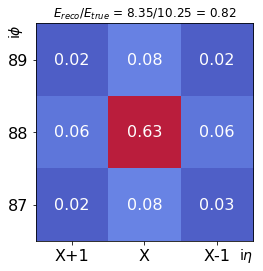

In [7]:
## plot hitmap for seed crystals in iEta iPhi of interest
iEtaiPhi_interests = [[25,20], [24,20], [24,19], [23,18], 
                      [23,38], [23,58], [23,78],[23,98], 
                      [43,18], [63,18], [83,18]]
index_interests = np.zeros(len(iEtaiPhi_interests), dtype=np.int32) - 999
for idx1 in range(len(X_train_gamma1)):
    allFound = True
    for idx2 in range(len(index_interests)):
        if X_train_gamma1[idx1,:,:,3][1][1] == iEtaiPhi_interests[idx2][0] and X_train_gamma1[idx1,:,:,4][1][1] == iEtaiPhi_interests[idx2][1]:
            index_interests[idx2] = idx1
        if index_interests[idx2] < 0:
            allFound = False
    if allFound:
        break
for idx in range(len(iEtaiPhi_interests)):
    plot_3x3gapmap(X_train_gamma1[index_interests[idx],:,:,2],X_train_gamma1[index_interests[idx],:,:,3][1][1], X_train_gamma1[index_interests[idx],:,:,4][1][1])
    hitmap_this, ETrue_this = average_map(iEtaiPhi_interests[idx][0],iEtaiPhi_interests[idx][1],X_train_gamma1[:,:,:,0], Y_train_gamma1, X_train_gamma1[:,:,:,3], X_train_gamma1[:,:,:,4])  
    plot_3x3map(hitmap_this, iEtaiPhi_interests[idx][0],iEtaiPhi_interests[idx][1], ETrue_this)
    
## plot hitmap for seed crystals at constant iEta or iPhi
iEta_interests = [25, 24, 23, 43, 63, 83]
for idx in range(len(iEta_interests)):
    hitmap_this, ETrue_this = average_map_iEta_constant(iEta_interests[idx],X_train_gamma1[:,:,:,0], Y_train_gamma1, X_train_gamma1[:,:,:,3])  
    plot_3x3map_iEta_constant(hitmap_this, iEta_interests[idx], ETrue_this)
iPhi_interests = [20, 19, 18, 38, 58, 88]
for idx in range(len(iPhi_interests)):
    hitmap_this, ETrue_this = average_map_iPhi_constant(iPhi_interests[idx],X_train_gamma1[:,:,:,0], Y_train_gamma1, X_train_gamma1[:,:,:,4])  
    plot_3x3map_iPhi_constant(hitmap_this, iPhi_interests[idx], ETrue_this)

## Step3: benchmark correction - E/Etrue method

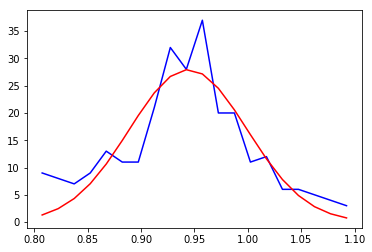

In [8]:
def getEoverEtrueMap(iEtaiX, iPhiiY, Etrue, Eraw): 
    map_cor = np.ones((170, 360)) ##barrel only
    sum_cor = np.zeros((170, 360))
    count_map = np.zeros((170, 360))
    for idx in range(len(Etrue)):
        if iEtaiX[idx] < -85 or iEtaiX[idx] > 85 or iEtaiX[idx] == 0:
            continue
        if iPhiiY[idx] < 1 or iPhiiY[idx] > 360:
            continue
        if Eraw[idx] <= 0.0:
            continue
        idx_ieta = 0
        if iEtaiX[idx] < 0:
            idx_ieta = int(iEtaiX[idx] + 85)
        if iEtaiX[idx] > 0:
            idx_ieta = int(iEtaiX[idx] + 84)
        idx_iphi = int(iPhiiY[idx]-1) % 20
        for iFold in range(18):
            sum_cor[idx_ieta][idx_iphi+iFold*20] = sum_cor[idx_ieta][idx_iphi+iFold*20] + Etrue[idx]/Eraw[idx]
            count_map[idx_ieta][idx_iphi+iFold*20] = count_map[idx_ieta][idx_iphi+iFold*20] +1.0
    
    for ix in range(170):
        for iy in range(360):
            if count_map[ix][iy] > 0:
                map_cor[ix][iy] = sum_cor[ix][iy]/count_map[ix][iy]
    return map_cor, count_map


def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

def fitGaussian(x_list, makePlot = False, plotname = 'test'):
    ydata, xdata_edges = np.histogram(x_list, bins = 20, range=(0.8, 1.1))
    xdata = np.zeros(len(ydata))
    for idx in range(len(ydata)):
        xdata[idx] = (xdata_edges[idx]+xdata_edges[idx+1])*0.5
    #print(xdata)
    #print(ydata)
    if ydata.max() < 6:
        return [1.0,1.0,1.0]
    try:
        popt, pcov = curve_fit(gaussian, xdata, ydata, p0=[ydata.max(), 0.95, 0.05])
        if makePlot:
            plt.clf()
            plt.plot(xdata, ydata, 'b-', label='data')
            plt.plot(xdata, gaussian(xdata, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
            plt.savefig('plots/fits/'+plotname+'.png')
            
        return popt
    except:
        return [1.0,1.0,1.0]

def getEoverEtrueMap_Fit(iEtaiX, iPhiiY, Etrue, Eraw): 
    map_cor = np.ones((170, 360)) ##barrel only
    EoverEtrue = []
    for idx1 in range(170):
        EoverEtrue.append([])
        for idx2 in range(20):
            EoverEtrue[idx1].append([])
        
    for idx in range(len(Etrue)):
        if iEtaiX[idx] < -85 or iEtaiX[idx] > 85 or iEtaiX[idx] == 0:
            continue
        if iPhiiY[idx] < 1 or iPhiiY[idx] > 360:
            continue
        if Etrue[idx] <= 0.0:
            continue
        idx_ieta = 0
        if iEtaiX[idx] < 0:
            idx_ieta = int(iEtaiX[idx] + 85)
        if iEtaiX[idx] > 0:
            idx_ieta = int(iEtaiX[idx] + 84)
        idx_iphi = int(iPhiiY[idx]-1) % 20
        EoverEtrue[idx_ieta][idx_iphi].append(Eraw[idx]/Etrue[idx])
    
    for ix in range(170):
        for iy in range(20):
            makePlot = False
            if ix == 3:
                makePlot = True
            popt = fitGaussian(EoverEtrue[ix][iy], makePlot, 'ieta_'+str(ix)+'_iphi_'+str(iy))
            if popt[1] > 0.0:
                for iFold in range(18):
                    map_cor[ix][iy+iFold*20] = 1.0/popt[1]
            
    return map_cor

map_corr = getEoverEtrueMap_Fit(X_train_gamma1[:,1,1,3], X_train_gamma1[:,1,1,4], Y_train_gamma1, Y_raw_train_gamma1)


In [9]:
def getCorrection(corr_map, iEtaiX, iPhiiY, Eraw):
    Ecorr = np.copy(Eraw)
    for idx in range(len(Eraw)):
        if iEtaiX[idx] < -85 or iEtaiX[idx] > 85 or iEtaiX[idx] == 0:
            continue
        if iPhiiY[idx] < 1 or iPhiiY[idx] > 360:
            continue
        if Eraw[idx] <= 0.0:
            continue
        idx_ieta = 0
        if iEtaiX[idx] < 0:
            idx_ieta = int(iEtaiX[idx] + 85)
        if iEtaiX[idx] > 0:
            idx_ieta = int(iEtaiX[idx] + 84)
        idx_iphi = int(iPhiiY[idx]-1)
        Ecorr[idx] = Eraw[idx] * corr_map[idx_ieta][idx_iphi]
    return Ecorr   
Y_cor_test_gamma1 = getCorrection(map_corr, X_test_gamma1[:, 1, 1, 3], X_test_gamma1[:, 1, 1, 4], Y_raw_test_gamma1)

## Step4: build and train the Pi0Net model

In [28]:
#x_train, x_valid, y_train, y_valid = train_test_split(X_train_gamma1, Y_train_gamma1, test_size=0.2, random_state=1992)
def getPi0Net():
    input_CNN = Input(shape=(3,3,3), name='input_CNN')
    input_Dense = Input(shape=(6,), name='input_Dense')

    model1 = Conv2D(16, (2, 2), padding='valid', activation='relu')(input_CNN)
    model1_out = Flatten()(model1)

    model2 = Conv2D(16, (1, 3), padding='valid', activation='relu')(input_CNN)
    model2_out = Flatten()(model2)

    model3 = Conv2D(16, (3, 1), padding='valid', activation='relu')(input_CNN)
    model3_out = Flatten()(model3)

    model_con1 = concatenate([model1_out, model2_out, model3_out])

    model_con1 = Dense(64, activation='relu')(model_con1)
    model_con1 = Dense(16, activation='relu')(model_con1)

    model_dense1 = Dense(16, activation='relu')(input_Dense)
    
    model_con2 = concatenate([model_con1, model_dense1])
    model_con2 = Dense(16, activation='relu')(model_con2)
    main_output = Dense(1)(model_con2)

    model = Model(inputs=[input_CNN,input_Dense], outputs=main_output)

    model.compile(optimizer='Adam',
                  loss='mean_absolute_error',
                  metrics=['accuracy'])
    return model

model = getPi0Net()
model.summary()
result_model = model.fit([X_train_gamma1[:,:,:,:3],X_train_dense_gamma1], np.divide(Y_raw_train_gamma1, Y_train_gamma1), epochs=100, batch_size=32)
#model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_valid, y_valid))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_CNN (InputLayer)          (None, 3, 3, 3)      0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 2, 2, 16)     208         input_CNN[0][0]                  
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 3, 1, 16)     160         input_CNN[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 1, 3, 16)     160         input_CNN[0][0]                  
__________________________________________________________________________________________________
flatten_7 

3538524/3538524 [==============================] - 114s 32us/step - loss: 0.1261 - acc: 5.6521e-07
Epoch 41/100
3538524/3538524 [==============================] - 115s 33us/step - loss: 0.1262 - acc: 5.6521e-07
Epoch 42/100
3538524/3538524 [==============================] - 116s 33us/step - loss: 0.1261 - acc: 5.6521e-07
Epoch 43/100
3538524/3538524 [==============================] - 118s 33us/step - loss: 0.1261 - acc: 5.6521e-07
Epoch 44/100
3538524/3538524 [==============================] - 116s 33us/step - loss: 0.1261 - acc: 5.6521e-07
Epoch 45/100
3538524/3538524 [==============================] - 116s 33us/step - loss: 0.1261 - acc: 5.6521e-07
Epoch 46/100
3538524/3538524 [==============================] - 115s 33us/step - loss: 0.1261 - acc: 5.6521e-07
Epoch 47/100
3538524/3538524 [==============================] - 116s 33us/step - loss: 0.1261 - acc: 5.6521e-07
Epoch 48/100
3538524/3538524 [==============================] - 116s 33us/step - loss: 0.1261 - acc: 5.6521e-07
Epoch

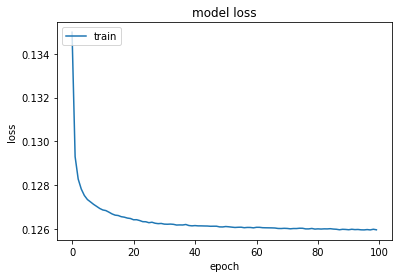

In [45]:
plt.plot(result_model.history['loss'])
#plt.plot(result_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
model2 = getPi0Net()
model2.summary()
result_model2 = model2.fit([X_train_gamma1[:,:,:,:3],X_train_dense_gamma1], Y_train_gamma1, epochs=100, batch_size=32)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_CNN (InputLayer)          (None, 3, 3, 3)      0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 2, 2, 16)     208         input_CNN[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 3, 1, 16)     160         input_CNN[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 1, 3, 16)     160         input_CNN[0][0]                  
__________________________________________________________________________________________________
flatten_10

3538524/3538524 [==============================] - 118s 33us/step - loss: 1.5995 - acc: 2.8260e-07
Epoch 41/100
3538524/3538524 [==============================] - 119s 34us/step - loss: 1.5993 - acc: 2.8260e-07
Epoch 42/100
3538524/3538524 [==============================] - 119s 34us/step - loss: 1.5993 - acc: 2.8260e-07
Epoch 43/100
3538524/3538524 [==============================] - 118s 33us/step - loss: 1.5994 - acc: 2.8260e-07
Epoch 44/100
3538524/3538524 [==============================] - 118s 33us/step - loss: 1.5992 - acc: 2.8260e-07
Epoch 45/100
3538524/3538524 [==============================] - 118s 33us/step - loss: 1.5991 - acc: 2.8260e-07
Epoch 46/100
3538524/3538524 [==============================] - 118s 33us/step - loss: 1.5989 - acc: 2.8260e-07
Epoch 47/100
3538524/3538524 [==============================] - 119s 34us/step - loss: 1.5989 - acc: 2.8260e-07
Epoch 48/100
3538524/3538524 [==============================] - 119s 34us/step - loss: 1.5986 - acc: 2.8260e-07
Epoch

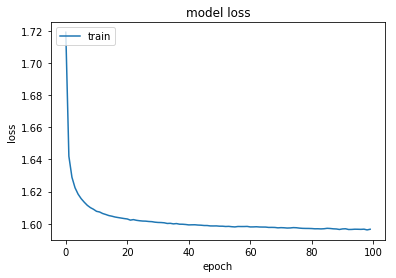

In [46]:
plt.plot(result_model2.history['loss'])
#plt.plot(result_model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:

def getDenseNet():
    input_Dense = Input(shape=(6,), name='input_Dense')
    model_dense1 = Dense(16, activation='relu')(input_Dense)
    model_dense2 = Dense(8, activation='relu')(model_dense1)
    main_output = Dense(1)(model_dense2)

    model = Model(inputs=[input_Dense], outputs=main_output)

    model.compile(optimizer='Adam',
                  loss='mean_absolute_error',
                  metrics=['accuracy'])
    return model
model_dense = getDenseNet()
model_dense.summary()
result_model_dense = model_dense.fit([X_train_dense_gamma1], Y_train_gamma1, epochs=100, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_Dense (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3538524/3538524 [==============================] - 85s 24us/step - loss: 1.9782 - acc: 0.0000e+00
Epoch 2/100
3538524/3538524 [==============================] - 86s 24us/step - loss: 1.9101 - acc: 0.0000e+00
Epoch 3/100
3538524/3538524 [===========================

3538524/3538524 [==============================] - 83s 23us/step - loss: 1.8854 - acc: 0.0000e+00
Epoch 68/100
3538524/3538524 [==============================] - 88s 25us/step - loss: 1.8854 - acc: 0.0000e+00
Epoch 69/100
3538524/3538524 [==============================] - 82s 23us/step - loss: 1.8855 - acc: 0.0000e+00
Epoch 70/100
3538524/3538524 [==============================] - 88s 25us/step - loss: 1.8854 - acc: 0.0000e+00
Epoch 71/100
3538524/3538524 [==============================] - 86s 24us/step - loss: 1.8854 - acc: 0.0000e+00
Epoch 72/100
3538524/3538524 [==============================] - 84s 24us/step - loss: 1.8853 - acc: 0.0000e+00
Epoch 73/100
3538524/3538524 [==============================] - 87s 24us/step - loss: 1.8853 - acc: 0.0000e+00
Epoch 74/100
3538524/3538524 [==============================] - 83s 23us/step - loss: 1.8852 - acc: 0.0000e+00
Epoch 75/100
3538524/3538524 [==============================] - 87s 25us/step - loss: 1.8852 - acc: 0.0000e+00
Epoch 76/100
3

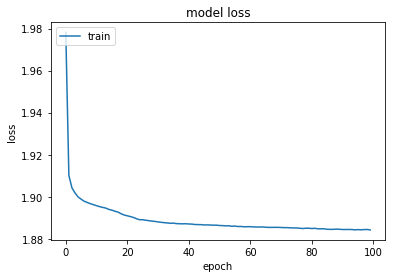

In [47]:
plt.plot(result_model_dense.history['loss'])
#plt.plot(result_model_dense.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
## decision tree

model_xgboost = XGBRegressor()
model_xgboost.fit(X_train_dense_gamma1, Y_train_gamma1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [31]:
print(Y_raw_test_gamma1[:10])

[19.02309418 16.09029198  5.26825333  5.6262455  13.66391468  5.51411963
  5.22126102 15.73054218 13.03283596  9.44814587]


In [32]:
Y_predict_xgboost_test_gamma1 = model_xgboost.predict(X_test_dense_gamma1)
print(Y_predict_xgboost_test_gamma1)

[17.083008  17.007511   6.615055  ...  7.9204154  6.368197  11.069525 ]


In [33]:
EoverEtrue_predict_test_gamma1 = model.predict([X_test_gamma1[:,:,:,:3], X_test_dense_gamma1]).flatten()
Y_predict_test_gamma1 = np.divide(Y_raw_test_gamma1, EoverEtrue_predict_test_gamma1)
print(Y_predict_test_gamma1[:10])

[19.78750575 13.2715733   5.3266678   6.07211162 13.72169851 13.3877027
  5.61601993 16.22606276 13.83364765  9.66565222]


In [34]:
Y_predict_model2_test_gamma1 = model2.predict([X_test_gamma1[:,:,:,:3], X_test_dense_gamma1]).flatten()
print(Y_predict_model2_test_gamma1[:10])

[19.52756   13.181158   5.3793683  5.9520226 13.653341  16.280735
  5.7013793 16.163157  13.772257   9.18182  ]


In [35]:
Y_predict_dense_test_gamma1 = model_dense.predict([X_test_dense_gamma1]).flatten()
print(Y_predict_dense_test_gamma1[:10])

[16.233952  16.643929   5.5802984  6.176365   9.791723  14.607727
  5.631589  16.4139    11.717102   9.16927  ]


In [36]:
print(Y_test_gamma1[:10])

[20.06212425 12.81198978  5.43744421  6.06228495 10.71784306 19.00874138
  6.65722895 16.41085815 13.98484993  9.68479061]


## Step 4: plot the energy response before and after correction

In [37]:
def effSigma(a):
    #input: an array
    #output: the smallest width which contains 68.3% of the distribution
    rlim = 0.683
    quantile_scan = np.arange(0.0, 1-rlim, 0.001)
    min_width = a.max() - a.min()
    for q in quantile_scan:
        aLeft = np.quantile(a, q)
        aRight = np.quantile(a, q+rlim)
        if aRight - aLeft < min_width:
            min_width = aRight - aLeft
    return min_width

In [38]:
def plot_E_over_Etrue(Y_true, Y_raw, Y_cor, plotname):
    plt.clf()
    Y_raw_over_true = []
    Y_cor_over_true = []
    Y_raw_over_true = np.divide(Y_raw, Y_true)
    Y_cor_over_true = np.divide(Y_cor, Y_true)
    std_raw = np.std(Y_raw_over_true)
    std_cor = np.std(Y_cor_over_true)
    eff_sig_raw = effSigma(Y_raw_over_true)
    eff_sig_cor = effSigma(Y_cor_over_true)
    plt.hist(Y_cor_over_true, bins=200, range=(0,1.68), alpha=0.5, label='$E_{cor}$/$E_{true}$, $\sigma_{eff}$=%.2f'%eff_sig_cor)
    plt.hist(Y_raw_over_true, bins=200, range=(0,1.68), alpha=0.5, label='$E_{raw}$/$E_{true}$, $\sigma_{eff}$=%.2f'%eff_sig_raw)
    plt.legend(fontsize=13, loc='upper left')
    plt.xlabel('E/$E_{true}$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=6)
    plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14, labelpad=6)
    #plt.show()
    plt.savefig('plots/'+plotname+'.pdf')
    plt.savefig('plots/'+plotname+'.png')

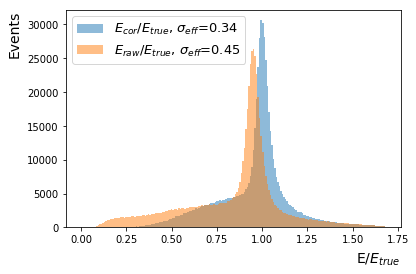

In [39]:
plot_E_over_Etrue(Y_test_gamma1, Y_raw_test_gamma1, Y_predict_test_gamma1, "EoverEtrue_gamma1")

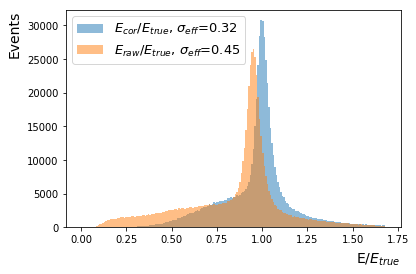

In [40]:
plot_E_over_Etrue(Y_test_gamma1, Y_raw_test_gamma1, Y_predict_model2_test_gamma1, "EoverEtrue_gamma1_model2")

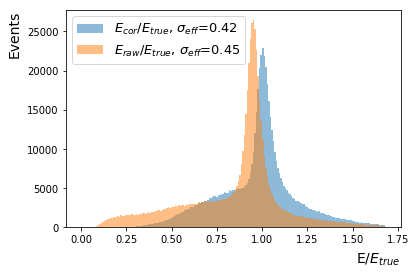

In [41]:
plot_E_over_Etrue(Y_test_gamma1, Y_raw_test_gamma1, Y_predict_dense_test_gamma1, "EoverEtrue_gamma1_dense")

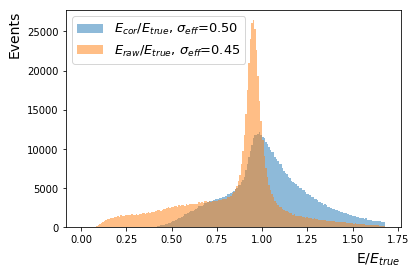

In [42]:
plot_E_over_Etrue(Y_test_gamma1, Y_raw_test_gamma1, Y_predict_xgboost_test_gamma1, "EoverEtrue_gamma1_xgboost")

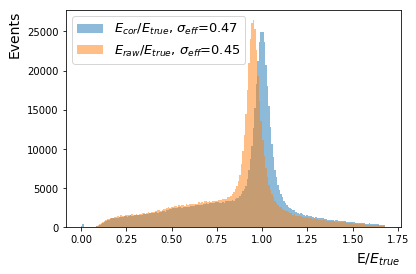

In [43]:
plot_E_over_Etrue(Y_test_gamma1, Y_raw_test_gamma1, Y_cor_test_gamma1, "EoverEtrue_gamma1_benchmark")

In [27]:
'''
Possible improvements:
1) change target from Etrue to E/Etrue
2) change loss function to hinge loss
3) add more variables to input_Dense
4) remove the iEta and iPhi input in input_CNN
'''

'\nPossible improvements:\n1) change target from Etrue to E/Etrue\n2) change loss function to hinge loss\n3) add more variables to input_Dense\n4) remove the iEta and iPhi input in input_CNN\n'